In [28]:

import os, warnings
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from flask import Flask, request, jsonify

warnings.filterwarnings("ignore")

In [29]:
# -----------------------------
# 1) CONFIG
# -----------------------------
MODEL_PATH = "assignee_model_all_projects.joblib"

PROJECTS = {
    "Aurora": {
        "issues":  r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Aurora Project\\Aurora Issues 554.csv",
        "summary": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Aurora Project\\Aurora Issues summery 568.csv",
        "sprints": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Aurora Project\\Aurora Sprints 41.csv",
    },
    "Meso": {
        "issues":  r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Meso Project\\Mesos Stories 176.csv",
        "summary": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Meso Project\\MESO Issue Summary 370.csv",
        "sprints": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Meso Project\\MESO Sprint 96.csv",
    },
    "SpringXD": {
        "issues":  r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Spring XD Project by Randula\\Spring XD Issues 1992.csv",
        "summary": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Spring XD Project by Randula\\Spring XD Issues Summary 2861.csv",
        "sprints": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Spring XD Project by Randula\\Spring XD Sprints 67.csv",
    },
    "UserGrid": {
        "issues":  r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for UserGrid\\Usergrid Issues 824.csv",
        "summary": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for UserGrid\\Usergrid Issues Summary 929.csv",
        "sprints": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for UserGrid\\Usergrid Sprints 36.csv",
    },
}

In [30]:
# -----------------------------
# 2) HELPER FUNCTIONS
# -----------------------------
def _lower_cols(df):
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
    return df

def safe_div(a,b,default=0.0):
    try:
        return float(a)/float(b) if b and not pd.isna(b) else default
    except: return default

def _parse_date(x):
    try: return pd.to_datetime(x, errors="coerce")
    except: return np.nan

In [31]:
# -----------------------------
# 3) LOAD & MERGE ALL PROJECTS
# -----------------------------
combined = []
for pname, p in PROJECTS.items():
    try:
        iss = _lower_cols(pd.read_csv(p["issues"], on_bad_lines="skip", engine="python"))

        # --- normalize column names ---
        rename_map = {
            "priority": "priorityid",
            "priority_id": "priorityid",
            "storypoints": "storypoint",
        }
        iss.rename(columns={k:v for k,v in rename_map.items() if k in iss.columns}, inplace=True)

        summ = _lower_cols(pd.read_csv(p["summary"], on_bad_lines="skip", engine="python"))
        spr  = _lower_cols(pd.read_csv(p["sprints"], on_bad_lines="skip", engine="python"))
    except Exception as e:
        print(f"⚠️ {pname}: error loading -> {e}")
        continue

    # Sprint features
    for c in ["sprintstartdate","sprintenddate"]:
        if c in spr.columns: spr[c] = spr[c].apply(_parse_date)
    if "sprintlength" not in spr.columns:
        spr["sprintlength"] = (spr["sprintenddate"] - spr["sprintstartdate"]).dt.days.clip(lower=1)
    spr["velocity_sp_per_day"] = spr.apply(lambda r: safe_div(r.get("completedissuesestimatesum",0), r.get("sprintlength",0)), axis=1)

    # Merge summary + sprint + issues
    join = summ.merge(spr, on="sprintid", how="left", suffixes=("","_spr"))
    if "issuekey" in join.columns and "key" in iss.columns:
        join = join.merge(
            iss[["key","storypoint","issuetype","status","assignee","priorityid"]],
            left_on="issuekey", right_on="key", how="left"
        )

    # Unify assignee columns
    if "assignee_x" in join.columns and "assignee_y" in join.columns:
        join["assignee"] = join["assignee_y"].fillna(join["assignee_x"])
    elif "assignee_x" in join.columns:
        join.rename(columns={"assignee_x": "assignee"}, inplace=True)
    elif "assignee_y" in join.columns:
        join.rename(columns={"assignee_y": "assignee"}, inplace=True)

    join["project"] = pname
    combined.append(join)

df = pd.concat(combined, ignore_index=True)
print("Loaded combined shape:", df.shape)

Loaded combined shape: (7054, 42)


In [32]:
# -----------------------------
# 4) FEATURES
# -----------------------------
num_feats = [
    "storypoint","priorityid","velocity_sp_per_day",
    "sprintlength","completedissuesestimatesum","noofdevelopers"
]
for nf in num_feats:
    if nf not in df.columns: df[nf] = 0

cat_feats = ["issuetype","status","project"]
for cf in cat_feats:
    if cf not in df.columns: df[cf] = "Unknown"

In [33]:
print("Columns in combined df:", list(df.columns))


Columns in combined df: ['projectid', 'sprintid', 'status_x', 'storyid', 'issuekey', 'summary', 'priorityid_x', 'assignee_x', 'initialstorypoint', 'currentstorypoint', 'sprintname', 'sprintstate', 'sprintstartdate', 'sprintenddate', 'sprintcompletedate', 'total', 'completedissuescount', 'issuesnotcompletedincurrentsprint', 'puntedissues', 'issuescompletedinanothersprint', 'issuekeysaddedduringsprint', 'completedissuesinitialestimatesum', 'completedissuesestimatesum', 'puntedissuesinitialestimatesum', 'puntedissuesestimatesum', 'issuesnotcompletedinitialestimatesum', 'issuesnotcompletedestimatesum', 'issuescompletedinanothersprintinitialestimatesum', 'issuescompletedinanothersprintestimatesum', 'noofdevelopers', 'sprintlength', 'velocity_sp_per_day', 'key', 'storypoint', 'issuetype', 'status_y', 'assignee_y', 'priorityid_y', 'assignee', 'project', 'totalnumberofissues', 'issuescompletedinanothersprintestimatesum1', 'priorityid', 'status']


In [34]:
# -----------------------------
# 5) TARGET (ASSIGNEE)
# -----------------------------
if "assignee" not in df.columns:
    raise ValueError("No 'assignee' column found in dataset!")

mask = df["assignee"].notna() & (df["assignee"] != "")
df = df[mask]

X = df[num_feats + cat_feats]
y = df["assignee"].astype(str)

print("Training samples:", len(X), " | Unique assignees:", y.nunique())


Training samples: 6533  | Unique assignees: 119


In [35]:
# -----------------------------
# 6) MODEL TRAINING
# -----------------------------
pipe = Pipeline([
    ("prep", ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False))
        ]), num_feats),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_feats)
    ])),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

# Count issues per assignee
counts = y.value_counts()

# Keep only those with ≥ 2 samples
valid_assignees = counts[counts >= 2].index
mask = y.isin(valid_assignees)
X = X[mask]
y = y[mask]

print("Remaining assignees:", len(valid_assignees))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

Remaining assignees: 101



Top-1 Accuracy: 0.326
Top-3 Accuracy: 0.611
Top-5 Accuracy: 0.748

Classification report:
                           precision    recall  f1-score   support

            Abhinav Sinha       0.00      0.00      0.00         1
            Andrei Budnik       0.45      0.59      0.51        22
        Andrei Sekretenko       1.00      0.75      0.86         4
             Andy Clement       0.11      0.25      0.15         4
              Artem Bilan       0.00      0.00      0.00         1
   Ayesha Amrin Dastagiri       0.08      1.00      0.15         1
         Benjamin Bannier       0.50      1.00      0.67         1
          Benjamin Mahler       0.33      0.50      0.40         2
              Benno Evers       1.00      1.00      1.00        16
              Bill Farner       0.74      0.53      0.62        32
          Brandon Shelley       0.44      1.00      0.62         4
            Brian Wickman       0.50      0.64      0.56        11
           Chris Schaefer       1.00 

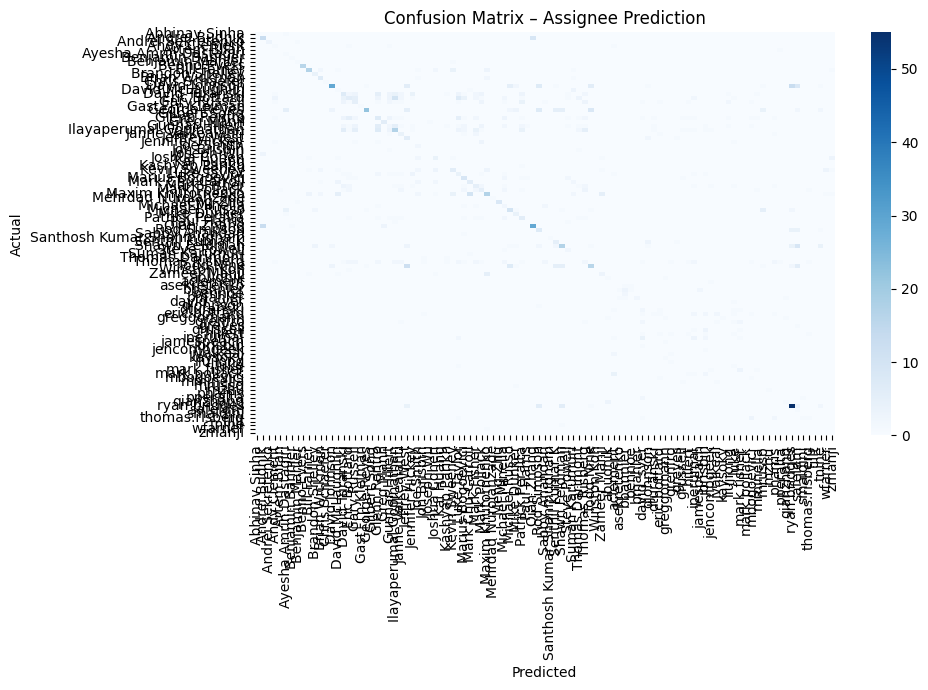

✅ Model saved to assignee_model_all_projects.joblib


In [36]:
# -----------------------------
# 7) EVALUATION (Top-k Accuracy)
# -----------------------------
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, top_k_accuracy_score

# --- Base Top-1 accuracy (same as normal accuracy)
top1_acc = accuracy_score(y_test, y_pred)

# --- Get predicted class probabilities
y_proba = pipe.predict_proba(X_test)

# --- Compute Top-3 and Top-5 accuracies
top3_acc = top_k_accuracy_score(y_test, y_proba, k=3, labels=pipe.named_steps["clf"].classes_)
top5_acc = top_k_accuracy_score(y_test, y_proba, k=5, labels=pipe.named_steps["clf"].classes_)

print(f"\nTop-1 Accuracy: {top1_acc:.3f}")
print(f"Top-3 Accuracy: {top3_acc:.3f}")
print(f"Top-5 Accuracy: {top5_acc:.3f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred))

# --- Confusion Matrix
plt.figure(figsize=(10,7))
cm = confusion_matrix(y_test, y_pred, labels=pipe.named_steps["clf"].classes_)
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=pipe.named_steps["clf"].classes_,
            yticklabels=pipe.named_steps["clf"].classes_)
plt.title("Confusion Matrix – Assignee Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

joblib.dump(pipe, MODEL_PATH)
print(f"✅ Model saved to {MODEL_PATH}")


In [37]:
# -----------------------------
# 8) INFERENCE & API (TOP-K MODE)
# -----------------------------
def predict_assignee(items, top_k=5):
    results = []
    for it in items:
        # ensure all required columns exist
        row = {**{k: 0 for k in num_feats}, **{k: "Unknown" for k in cat_feats}}
        row.update(it)
        df_one = pd.DataFrame([row])

        # get class probabilities
        proba = pipe.predict_proba(df_one[num_feats + cat_feats])[0]
        classes = pipe.named_steps["clf"].classes_

        # sort and pick top-k
        top_idx = np.argsort(proba)[::-1][:top_k]
        top_preds = [
            {"assignee": classes[i], "probability": float(proba[i])}
            for i in top_idx
        ]
        results.append({"top_k_recommendations": top_preds})
    return results

In [40]:
# -----------------------------
# 9) LOCAL DUMMY TEST
# -----------------------------
if __name__ == "__main__":
    print("\n=== Running Dummy Assignee Predictions (Top-5) ===")
    dummy_items = [
        {
            "issuetype": "Story",
            "status": "To Do",
            "storypoint": 5,
            "priorityid": 3,
            "sprintlength": 14,
            "noofdevelopers": 6,
            "project": "Aurora"
        },
        {
            "issuetype": "Bug",
            "status": "In Progress",
            "storypoint": 2,
            "priorityid": 1,
            "sprintlength": 10,
            "noofdevelopers": 4,
            "project": "Meso"
        },
        {
            "issuetype": "Task",
            "status": "To Do",
            "storypoint": 13,
            "priorityid": 4,
            "sprintlength": 21,
            "noofdevelopers": 8,
            "project": "SpringXD"
        },
        {
            "issuetype": "Improvement",
            "status": "To Do",
            "storypoint": 3,
            "priorityid": 2,
            "sprintlength": 14,
            "noofdevelopers": 5,
            "project": "UserGrid"
        },
        {
            "issuetype": "Bug",
            "priorityid": 3,
            "storypoint": 5,
            "project": "TKTI"
        }
    ]

    preds = predict_assignee(dummy_items, top_k=5)
    for i, res in enumerate(preds, start=1):
        print(f"\nTest #{i}: {dummy_items[i-1]['project']} / {dummy_items[i-1]['issuetype']}")
        for rank, rec in enumerate(res["top_k_recommendations"], start=1):
            print(f"  {rank}. {rec['assignee']} ({rec['probability']*100:.2f}%)")




=== Running Dummy Assignee Predictions (Top-5) ===

Test #1: Aurora / Story
  1. Bill Farner (45.53%)
  2. Kevin Sweeney (16.98%)
  3. zmanji (14.16%)
  4. Santhosh Kumar Shanmugham (7.44%)
  5. Maxim Khutornenko (6.03%)

Test #2: Meso / Bug
  1. Qian Zhang (33.67%)
  2. Benjamin Bannier (32.67%)
  3. Meng Zhu (9.00%)
  4. Andrei Budnik (5.33%)
  5. Gary Russell (3.67%)

Test #3: SpringXD / Task
  1. Andrei Sekretenko (13.67%)
  2. Patrick Peralta (9.61%)
  3. Benno Evers (7.33%)
  4. Ilayaperumal Gopinathan (6.69%)
  5. Gary Russell (6.67%)

Test #4: UserGrid / Improvement
  1. ryan bridges (60.15%)
  2. Shawn Feldman (36.00%)
  3. George Reyes (1.66%)
  4. Todd Nine (1.15%)
  5. Rod Simpson (0.73%)

Test #5: TKTI / Bug
  1. Maxim Khutornenko (16.11%)
  2. Gast├│n Kleiman (14.00%)
  3. Gary Russell (12.00%)
  4. Suman Karumuri (6.26%)
  5. Bill Farner (6.16%)
